# TP02 - Cross entropy loss and handwritten character recognition
In this practical, we will first **re-implement the cross entropy loss**, and then write our first proper **training and testing pipeline** for a **handwritten character recognition task** (small version of the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset).

**FYI:** GPUs are not necessary for this practical.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


# Part A - Reimplementing cross entropy

## A.0 - Combining losses
First, we recall that, for a batch of score vectors $s\in\mathbb{R}^{n\times C}$ and true labels $y\in[1,C]^n$, **cross entropy** is defined as
$$CE(s, y) = -\frac{1}{n}\sum_{i=1}^n \log\left( \mbox{softmax}(s_i)_{y_i} \right)$$

where $\mbox{softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$ is the probability associated to class $i\in[1,C]$ for a score vector $x\in\mathbb{R}^C$.

Let's try to compute cross-entropy in three different ways (see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)):
1. Using `nn.CrossEntropyLoss()`.
2. Using `nn.NLLLoss()` and `nn.LogSoftmax()`.
3. Using `nn.NLLLoss()` and `nn.Softmax()`.

Check that the output is the same for all three methods on Gaussian random scores `torch.randn(n_batch, n_classes)` and random labels `torch.randint(0, n_classes, [n_batch])`, where `n_batch=4` and `n_classes=10`. Note that the scores are real valued vectors while the labels are integers corresponding to the true class.

In [2]:
### YOUR CODE HERE ###
cross_entropy = nn.CrossEntropyLoss()
log_loss = nn.NLLLoss()
softmax = nn.Softmax(dim=1)
log_softmax = nn.LogSoftmax(dim=1)

n_batch = 4
n_classes = 10
scores = torch.randn(n_batch, n_classes)
true_labels = torch.randint(0, n_classes, [n_batch])

print("Method 1:", cross_entropy(scores, true_labels).item())
print("Method 2:", log_loss(log_softmax(scores), true_labels).item())
print("Method 3:", log_loss(torch.log(softmax(scores)), true_labels).item())

Method 1: 2.9627113342285156
Method 2: 2.9627113342285156
Method 3: 2.9627113342285156


## A.1 - Re-implementation
Now re-implement cross-entropy using base functions (`torch.log`, `torch.exp`, `torch.sum`, etc...). Verify that your function returns the same value as Pytorch's implementation.

In [3]:
### YOUR CODE HERE ###
def ce_naive(p, q):
    p = torch.exp(p)
    p /= torch.sum(p, dim=1, keepdim=True)
    p = p[range(q.shape[0]),q]
    return -torch.mean(torch.log(p))

print("Pytorch:", cross_entropy(scores, true_labels).item())
print("Ours:   ", ce_naive(scores, true_labels).item())

Pytorch: 2.9627113342285156
Ours:    2.9627113342285156


## A.2 - Stability analysis
Softmax probabilities can be relatively unstable due to their use of exponentials. Pytorch implementations thus usually use log probas or logits to avoid overflows or floating point errors. Test all methods (including your own) on Gaussian random scores of standard deviation equal to $100$. Which methods are stable? Why? Is it an issue in practice?

In [4]:
### YOUR CODE HERE ###
n_batch = 4
n_classes = 10
scores = 100 * torch.randn(n_batch, n_classes)
true_labels = torch.randint(0, n_classes, [n_batch])

print("Method 1:", cross_entropy(scores, true_labels).item())
print("Method 2:", log_loss(log_softmax(scores), true_labels).item())
print("Method 3:", log_loss(torch.log(softmax(scores)), true_labels).item())
print("Ours:    ", ce_naive(scores, true_labels).item())

Method 1: 55.43902587890625
Method 2: 55.43902587890625
Method 3: inf
Ours:     nan


Re-implement a stable version of cross-entropy.

In [5]:
### YOUR CODE HERE ###
def ce_stable(p, q):
    p -= torch.max(p, dim=1, keepdim=True).values
    return torch.mean(torch.log(torch.sum(torch.exp(p), dim=1)) - p[range(q.shape[0]),q])

print("Pytorch:", cross_entropy(scores, true_labels).item())
print("Ours:   ", ce_stable(scores, true_labels).item())

Pytorch: 55.43902587890625
Ours:    55.43902587890625


# Part B - Handwritten character recognition

## B.0 - Dataloader
Import `load_digits` from `sklearn.datasets` (see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)), load the corresponding dataset and extract the images, data (i.e. flattened version of the images) and targets (i.e. the labels).

In [6]:
### YOUR CODE HERE ###
from sklearn.datasets import load_digits

dataset = load_digits()
images = dataset['images']
X_numpy = dataset['data']
y_numpy = dataset['target']
X = torch.Tensor(X_numpy)
y = torch.LongTensor(y_numpy)
X.shape

torch.Size([1797, 64])


Display the first image and its label.

tensor(0)

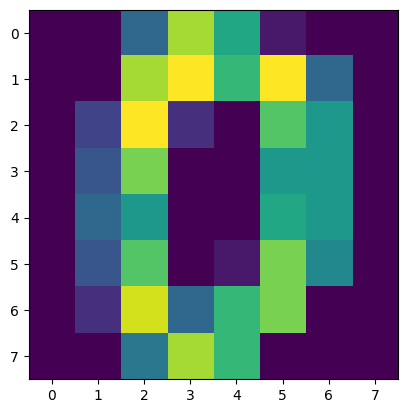

In [7]:
### YOUR CODE HERE ###
plt.imshow(images[0])
y[0]

Then, create two PyTorch datasets and dataloaders with a batch size of $50$ for this task: one for the train (80% of the dataset) and one for the test (remaining 20% of the dataset).

In [8]:
### YOUR CODE HERE ###
n_data = X.shape[0]
n_train = int(0.8 * n_data)

rand_perm = np.random.permutation(n_data)
ids_train = rand_perm[:n_train]
ids_test = rand_perm[n_train:]

train_dataset = torch.utils.data.TensorDataset(X[ids_train], y[ids_train])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X[ids_test], y[ids_test])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=False)

## B.1 - Model creation

Create a class MLP that creates an MLP of given width and depth, and use it to create a 3-layer MLP of width $100$. We will assume that `width > 0` and `depth > 0`.

In [9]:
### YOUR CODE HERE ###
class MLP(nn.Module):
    def __init__(self, width, depth):
        super().__init__()
        layers = []
        if depth == 1:
            layers.append(nn.Linear(64, 10))
        else:
            layers += [nn.Linear(64, width), nn.ReLU()]
            for _ in range(depth - 2):
                layers += [nn.Linear(width, width), nn.ReLU()]
            layers += [nn.Linear(width, 10)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

model = MLP(100, 3)
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=64, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)


## B.2 - Loss and optimizer
Create a cross entropy loss.

In [10]:
### YOUR CODE HERE ###
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

## B.3 - Training and testing loops
Finally, create the functions `train(model, epoch)` and `test(model)` to train (one epoch with SGD and a learning rate of $10^{-3}$) and test your model.

In [11]:
### YOUR CODE HERE ###
def train(model, epoch):
    model.to(device)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    running_loss, running_acc = 0., 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        #print(inputs.size())
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item()
        running_acc += torch.sum(preds == targets)
    print(f"[TRAIN epoch {epoch}] Loss: {running_loss/n_train:.2f} Acc: {100 * running_acc/n_train:.2f}%")

def test(model):
    n_test = n_data - n_train
    model.to(device)
    model.eval()
    running_loss, running_acc = 0., 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            preds = torch.argmax(outputs, 1)
            running_loss += loss.item()
            running_acc += torch.sum(preds == targets)
    print(f"[TEST] Loss: {running_loss/n_test:.2f} Acc: {100 * running_acc/n_test:.2f}%")

Train your model for 200 epochs and display the test loss and accuracy every 10 epochs.

In [12]:
### YOUR CODE HERE ###
for epoch in range(200):
    train(model, epoch)
    if epoch % 10 == 0:
        test(model)

torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([37, 64])
[TRAIN epoch 0] Loss: 1.11 Acc: 66.46%
[TEST] Loss: 0.42 Acc: 88.06%
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.Size([50, 64])
torch.S

KeyboardInterrupt: 

## B.4 - Analyze the results

Create a confusion matrix on the train and test datasets using `ConfusionMatrixDisplay.from_predictions` from `sklearn.metrics`. Which digits are confused?

In [ ]:
### YOUR CODE HERE ###
from sklearn.metrics import ConfusionMatrixDisplay

predictions = torch.argmax(model(X[ids_train]), 1)
ConfusionMatrixDisplay.from_predictions(y[ids_train], predictions)

predictions = torch.argmax(model(X[ids_test]), 1)
ConfusionMatrixDisplay.from_predictions(y[ids_test], predictions)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

## B.5 - PCA and TSNE visualizations (optional)

To check wether the problem is easily to solve, plot the PCA and TSNE visualization of the dataset, where each digit corresponds to a different color. Are the digits/classes well separated?

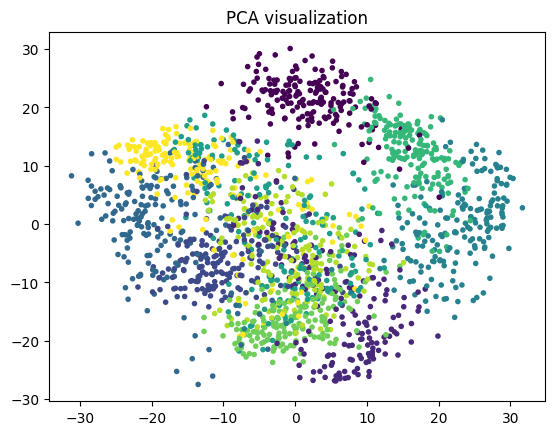

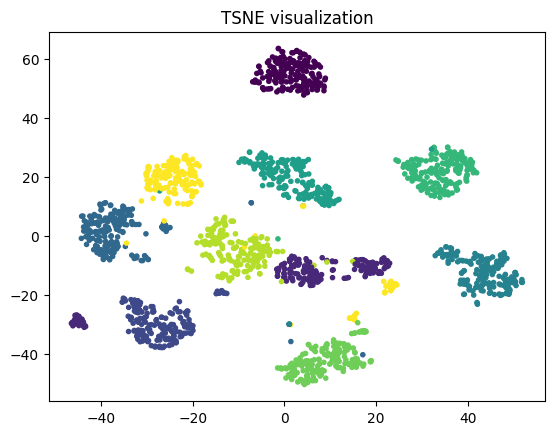

In [ ]:
### YOUR CODE HERE ###
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, marker='.')
plt.title("PCA visualization")
plt.show()

tsne = TSNE(init='pca')
X_tsne = tsne.fit_transform(X)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, marker='.')
plt.title("TSNE visualization")
plt.show()

## B.6 - Model complexity (optional)
How many parameters does the model have? Are they necessary? Try different architectures, including a linear model (use `bias=False` in `nn.Linear` to remove the bias term).

In [ ]:
### YOUR CODE HERE ###
model_lin = nn.Linear(64, 10, bias=False)
print("Number of parameters of the MLP:", sum(p.numel() for p in model.parameters()))
print("Number of parameters of the linear model:", sum(p.numel() for p in model_lin.parameters()))

for epoch in range(200):
    train(model_lin, epoch)
    if epoch % 10 == 0:
        test(model_lin)

Number of parameters of the MLP: 17610
Number of parameters of the linear model: 640
[TRAIN epoch 0] Loss: 0.04 Acc: 58.04%
[TEST] Loss: 0.01 Acc: 82.50%
[TRAIN epoch 1] Loss: 0.01 Acc: 86.15%
[TRAIN epoch 2] Loss: 0.01 Acc: 91.58%
[TRAIN epoch 3] Loss: 0.00 Acc: 93.25%
[TRAIN epoch 4] Loss: 0.00 Acc: 93.95%
[TRAIN epoch 5] Loss: 0.00 Acc: 94.57%
[TRAIN epoch 6] Loss: 0.00 Acc: 95.55%
[TRAIN epoch 7] Loss: 0.00 Acc: 96.45%
[TRAIN epoch 8] Loss: 0.00 Acc: 96.59%
[TRAIN epoch 9] Loss: 0.00 Acc: 96.52%
[TRAIN epoch 10] Loss: 0.00 Acc: 96.73%
[TEST] Loss: 0.00 Acc: 95.28%
[TRAIN epoch 11] Loss: 0.00 Acc: 97.01%
[TRAIN epoch 12] Loss: 0.00 Acc: 97.36%
[TRAIN epoch 13] Loss: 0.00 Acc: 97.22%
[TRAIN epoch 14] Loss: 0.00 Acc: 97.56%
[TRAIN epoch 15] Loss: 0.00 Acc: 97.36%
[TRAIN epoch 16] Loss: 0.00 Acc: 98.19%
[TRAIN epoch 17] Loss: 0.00 Acc: 98.05%
[TRAIN epoch 18] Loss: 0.00 Acc: 98.19%
[TRAIN epoch 19] Loss: 0.00 Acc: 98.12%
[TRAIN epoch 20] Loss: 0.00 Acc: 98.12%
[TEST] Loss: 0.00 Acc: 95